In [1]:
from utils import import_train_data
df, test_df = import_train_data()
df.sample(10)

,image_path,category,target,r
3559,data/알파벳인식/Z/Z/4d_al_Z_39.jpg,alphabet,Z,False
1055,data/알파벳인식/A/r_A/4d_al_r_a04.jpg,alphabet,A,True
870,data/숫자인식/08/r_n08/4d_r_n08_21.jpg,number,8,True
2966,data/알파벳인식/T/T/4d_al_T_46.jpg,alphabet,T,False
4112,data/자유패턴/a_r/a_r_01.jpg,free_pattern,None,None
170,data/숫자인식/01/r_n01/4d_r_n01_21.jpg,number,1,True
3255,data/알파벳인식/W/W/4d_al_W_35.jpg,alphabet,W,False
501,data/숫자인식/05/n05/4d_n05_01.jpg,number,5,False
3294,data/알파벳인식/W/r_W/4d_al_r_W_24.jpg,alphabet,W,True
417,data/숫자인식/04/n04/4d_n04_17.jpg,number,4,False


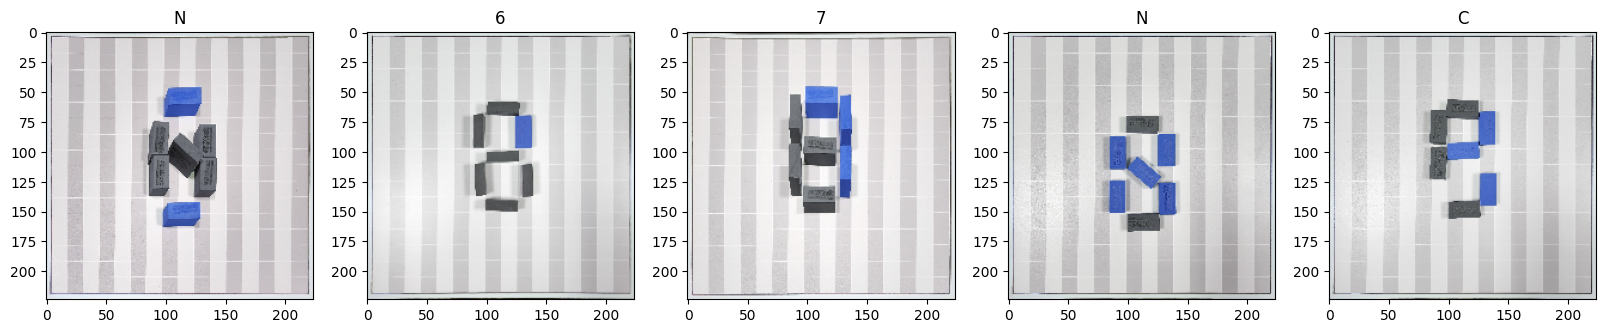

In [92]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from preprocessing import warp_to_board

def view_sample(df, process, n=5):
    fig, ax = plt.subplots(1, n, figsize=(20, 8))

    sample = df.sample(n)
    for i, (_, row) in enumerate(sample.iterrows()):
        image = cv2.imread(row['image_path'])
        image = process(image)
        ax[i].imshow(image)
        ax[i].set_title(row['target'])

    plt.show()

def compare_sample(df, process, process_2, n=5):
    fig, ax = plt.subplots(2, n, figsize=(20, 8))

    sample_idx = df.sample(n).index
    for i, idx in enumerate(sample_idx):
        image = cv2.imread(df.loc[idx, 'image_path'])
        ax[0][i].imshow(process(image))
        ax[0][i].set_title(idx)
        ax[1][i].imshow(process_2(image))

    plt.show()


view_sample(df, lambda x: cv2.resize(warp_to_board(x), (224, 224)))

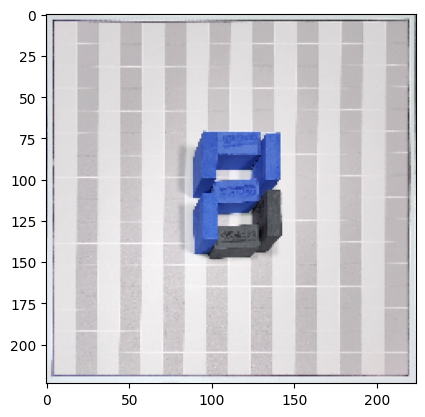

In [7]:
image = cv2.imread(df.sample(1).iloc[0]['image_path'])
image = warp_to_board(image)
image = cv2.resize(image, (224, 224))
plt.imshow(image)

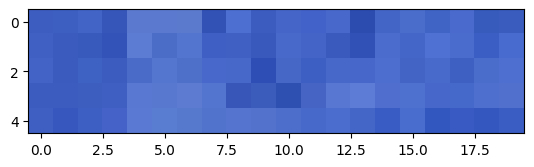

In [8]:
img_region = image[75:80, 100:120]
plt.imshow(img_region)

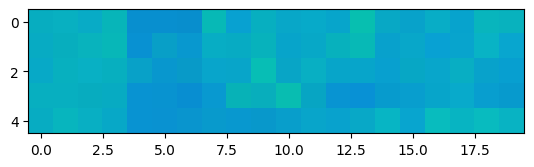

In [9]:
img_region_hsv = cv2.cvtColor(img_region, cv2.COLOR_BGR2HSV)
plt.imshow(img_region_hsv)

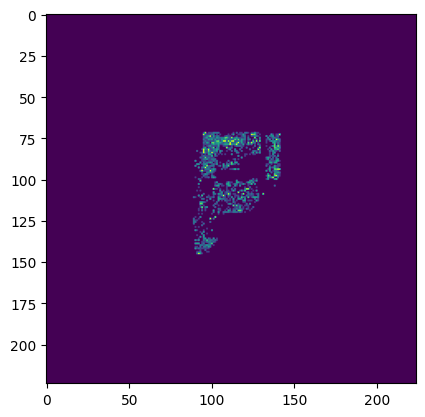

In [17]:
img_region_hist = cv2.calcHist([img_region_hsv], [0, 1], None, [180, 256], [0, 180, 0, 256])
cv2.normalize(img_region_hist, img_region_hist, 0, 255, cv2.NORM_MINMAX)
img_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
out = cv2.calcBackProject([img_hsv], [0, 1], img_region_hist, [0, 180, 0, 256], 1)
plt.imshow(out)

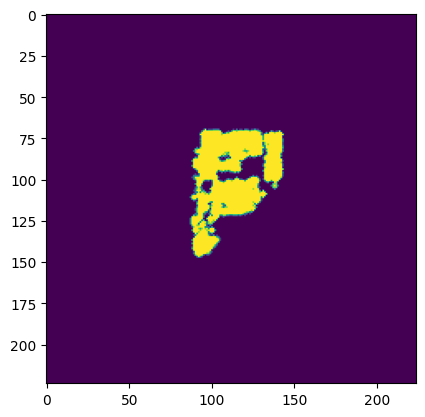

In [24]:
ellipse_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
cv2.filter2D(out, -1, ellipse_kernel, out)
plt.imshow(out)

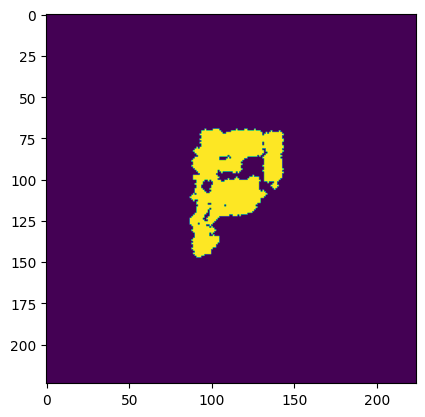

In [25]:
_, mask = cv2.threshold(out, 70, 255, 0)
plt.imshow(mask)

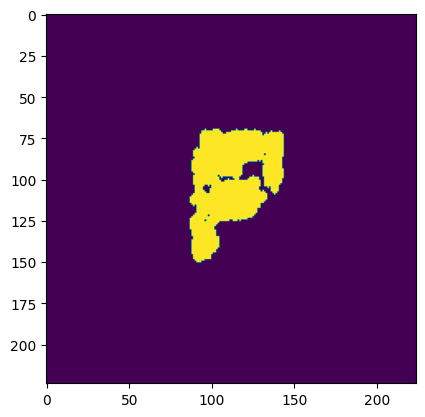

In [26]:
mask = cv2.dilate(mask, (3, 3), iterations=3)
plt.imshow(mask)

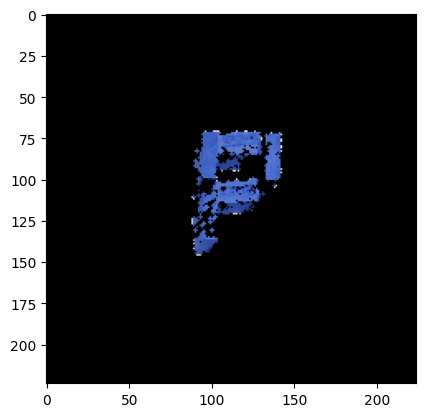

In [21]:
mask_3d = cv2.merge((mask, mask, mask))
img_seg = cv2.bitwise_and(image, mask_3d)
plt.imshow(img_seg)

otsu

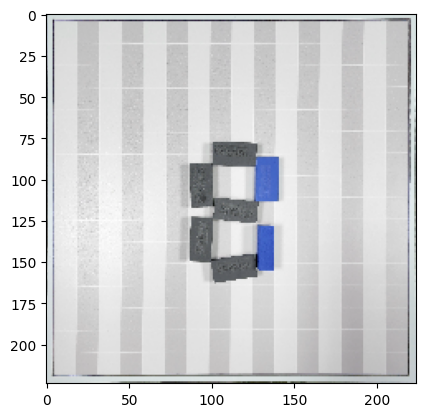

In [34]:
image = cv2.imread(df.sample(1).iloc[0]['image_path'])
image = warp_to_board(image)
image = cv2.resize(image, (224, 224))
plt.imshow(image)

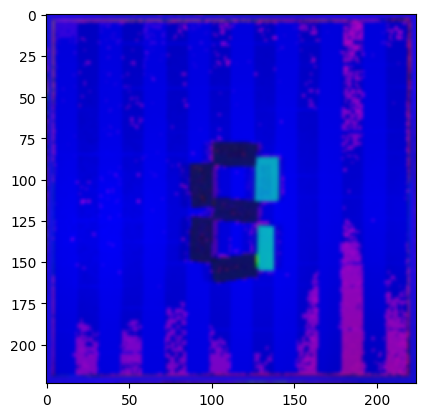

In [35]:
img_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
img_hsv = cv2.GaussianBlur(img_hsv, (5, 5), 0)
plt.imshow(img_hsv)

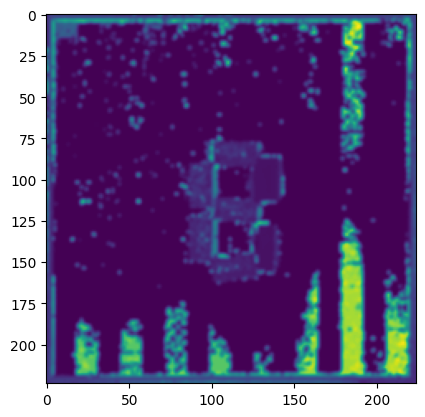

In [37]:
img_h = img_hsv[:, :, 0]
plt.imshow(img_h)

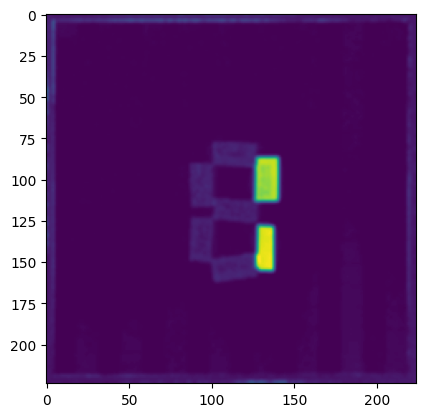

In [38]:
img_s = img_hsv[:, :, 1]
plt.imshow(img_s)

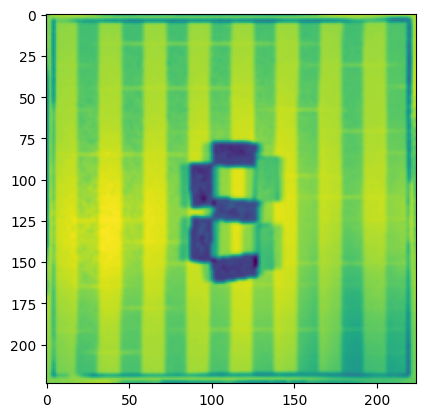

In [58]:
img_v = img_hsv[:, :, 2]
plt.imshow(img_v)

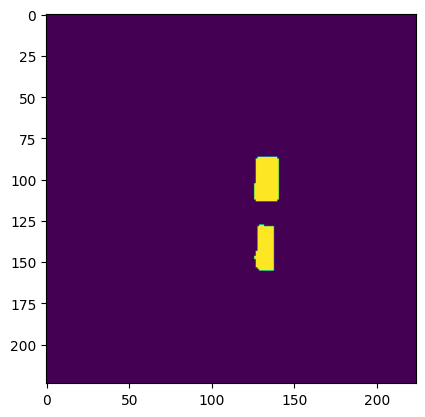

In [40]:
# use otsu thresholding on saturation channel
_, img_s = cv2.threshold(img_s, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plt.imshow(img_s)

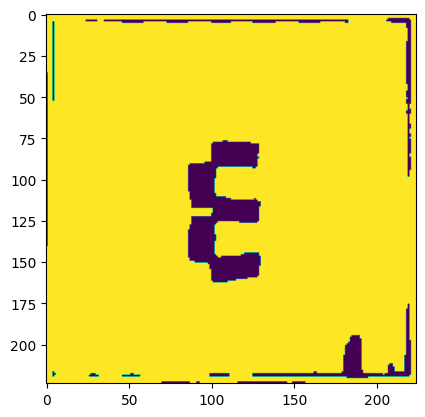

In [65]:
thresh_v, mask_v = cv2.threshold(img_v, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plt.imshow(mask_v)

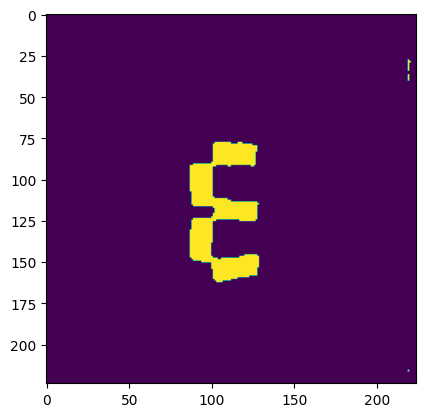

In [79]:
adjusted_threshold = int(thresh_v * 0.8)
adjusted_thresh = np.where(img_v >= adjusted_threshold, 255, 0).astype(np.uint8)
adjusted_thresh = cv2.bitwise_not(adjusted_thresh)
plt.imshow(adjusted_thresh)

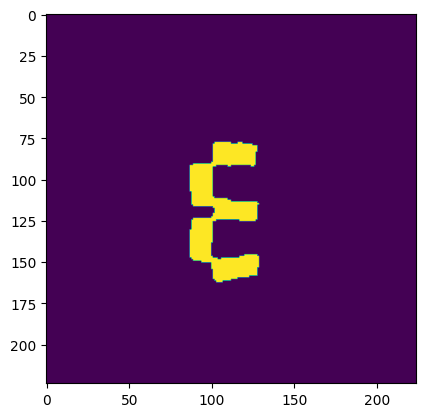

In [80]:
border = np.zeros_like(adjusted_thresh)
border[10:-10, 10:-10] = 255
# remove border from img_v
adjusted_thresh = cv2.bitwise_and(adjusted_thresh, adjusted_thresh, mask=border)
plt.imshow(adjusted_thresh)

In [152]:
def get_masks(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    image = cv2.GaussianBlur(image, (5, 5), 0)

    image_s = image[:, :, 1]
    thresh_s, orange = cv2.threshold(image_s, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    image_v = image[:, :, 2]
    thresh_v, _ = cv2.threshold(image_v, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    thresh_v = int(thresh_v * 0.85)

    gray = np.where(image_v >= thresh_v, 255, 0).astype(np.uint8)
    gray = cv2.bitwise_not(gray)    

    border = np.zeros_like(gray)
    border[10:-10, 10:-10] = 255
    gray = cv2.bitwise_and(gray, gray, mask=border)
    if thresh_s > 60: # if orange detected, remove orange region from gray
        gray = cv2.bitwise_and(gray, gray, mask=cv2.bitwise_not(orange))
    gray = cv2.dilate(gray, (3, 3), iterations=3)
    gray = cv2.erode(gray, (3, 3), iterations=3)

    return orange, gray

74.0 146
76.0 146
82.0 148
77.0 153
77.0 162


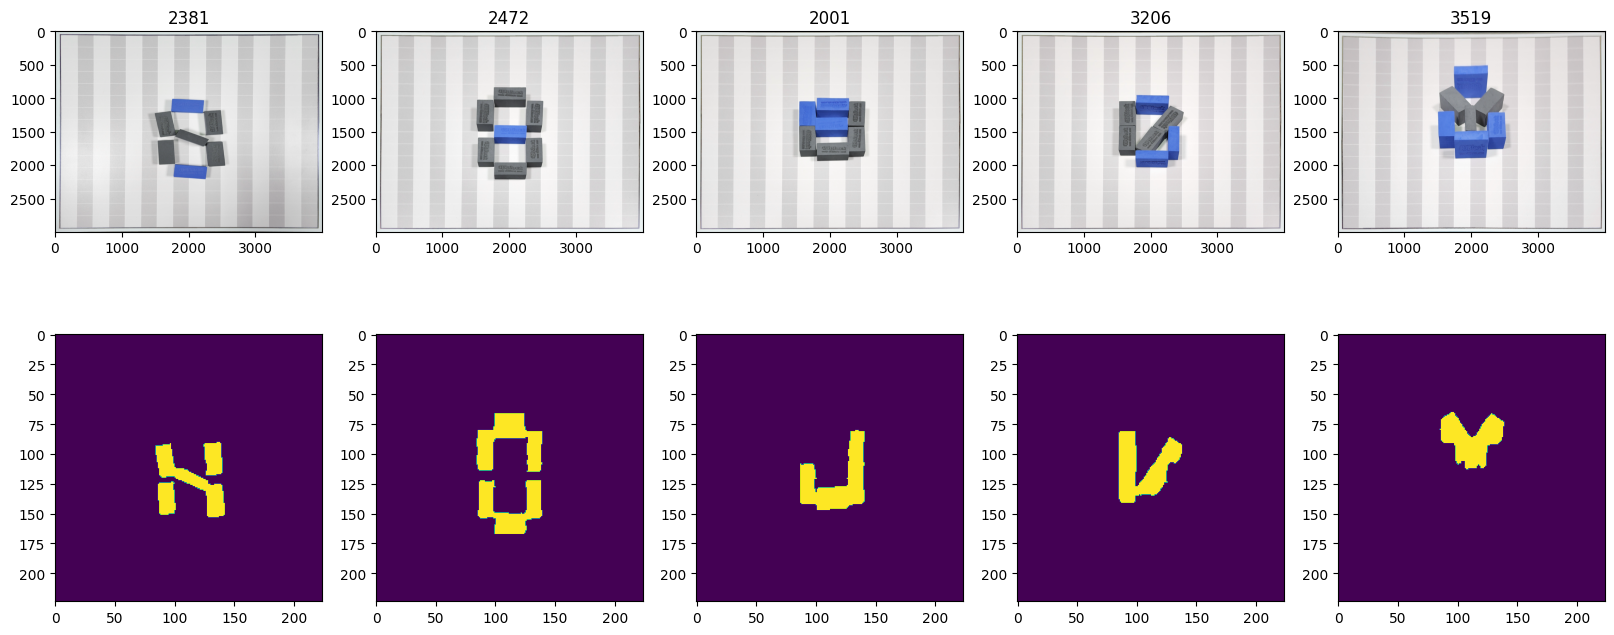

In [150]:
def pipe(image):
    image = warp_to_board(image)
    image = cv2.resize(image, (224, 224))
    orange, gray = get_masks(image)
    return gray

compare_sample(df[df['r']==True], warp_to_board, pipe)

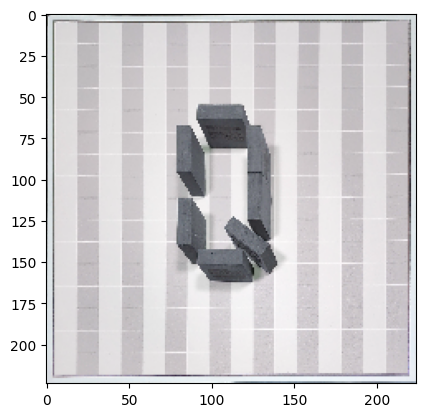

In [137]:
img = cv2.imread(df.iloc[2684]['image_path'])
img = warp_to_board(img)
img = cv2.resize(img, (224, 224))
plt.imshow(img)

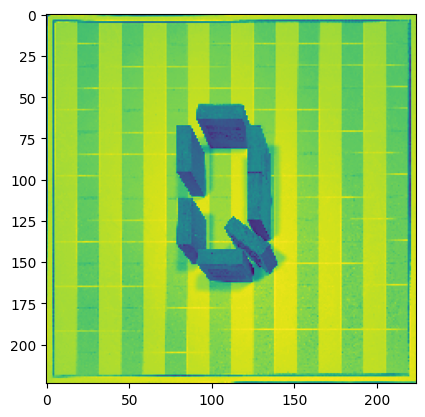

In [138]:
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
img_v = img_hsv[:, :, 2]
plt.imshow(img_v)

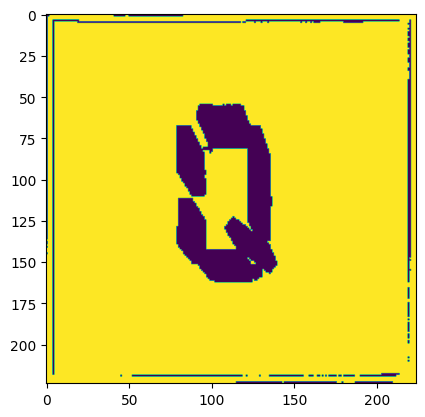

In [139]:
thresh, gray = cv2.threshold(img_v, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plt.imshow(gray)

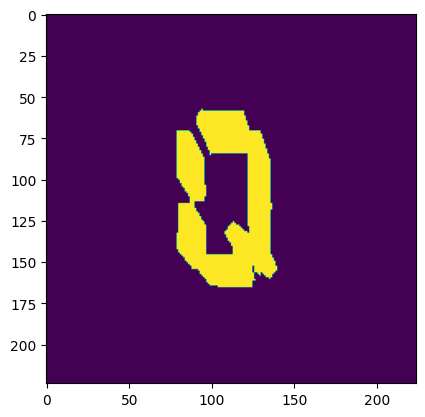

In [140]:
adjusted_thresh = int(thresh * 0.85)
gray = np.where(img_v >= adjusted_thresh, 255, 0).astype(np.uint8)
gray = cv2.bitwise_not(gray)
border = np.zeros_like(gray)
border[10:-10, 10:-10] = 255
gray = cv2.bitwise_and(gray, gray, mask=border)
gray = cv2.dilate(gray, (3, 3), iterations=3)
gray = cv2.erode(gray, (3, 3), iterations=3)
plt.imshow(gray)

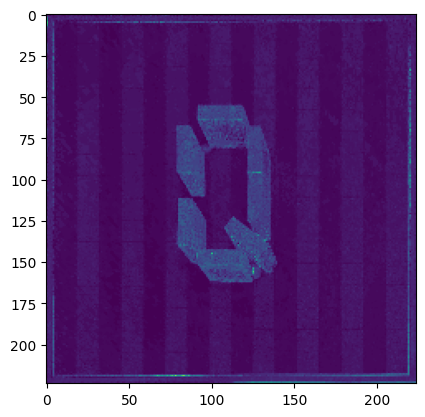

In [141]:
img_s = img_hsv[:, :, 1]
plt.imshow(img_s)

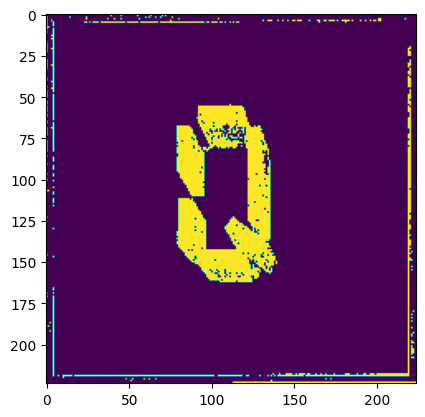

In [142]:
thresh_s, gray_s = cv2.threshold(img_s, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plt.imshow(gray_s)

In [143]:
thresh_s

15.0

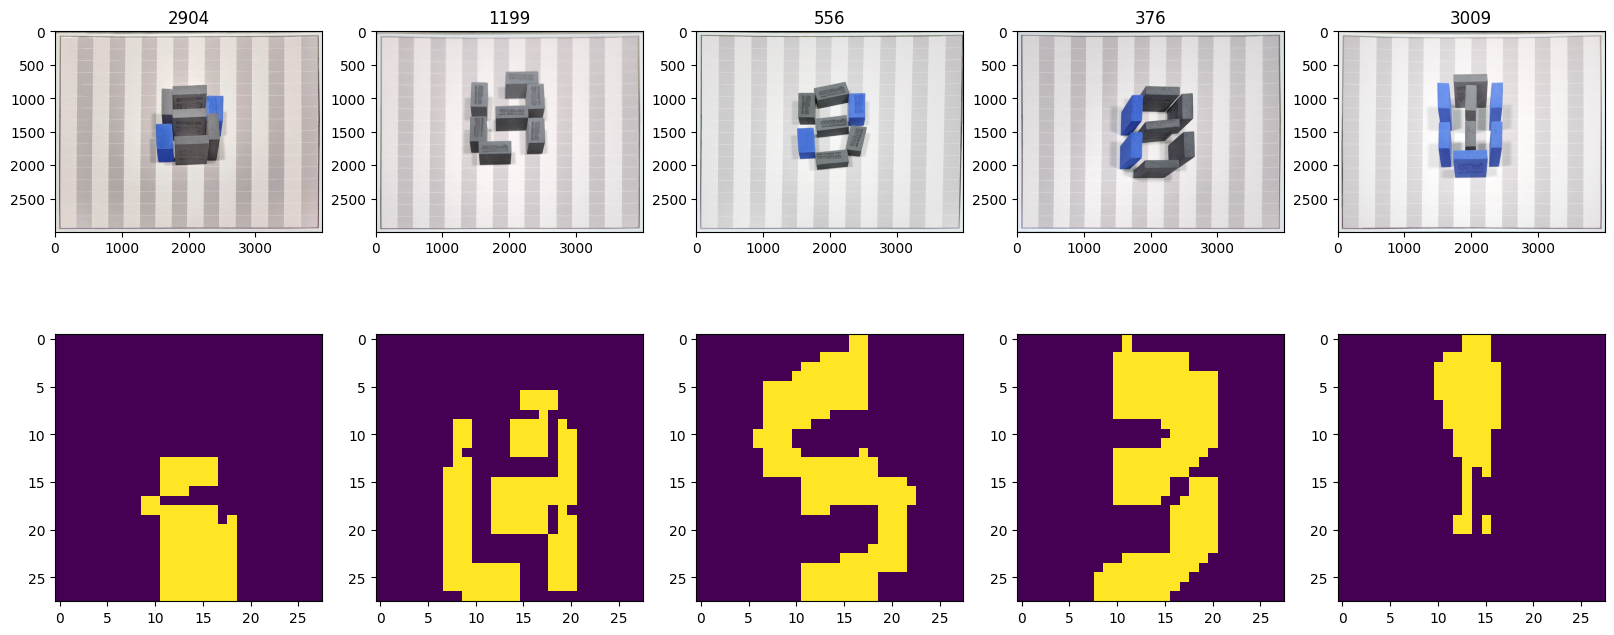

In [175]:
from preprocessing import mask_square

def pipe(image):
    image = warp_to_board(image)
    image = cv2.resize(image, (224, 224))
    orange, gray = get_masks(image)
    gray = mask_square(gray)
    gray = cv2.resize(gray, (28, 28), interpolation=cv2.INTER_NEAREST)
    gray = cv2.erode(gray, (3, 3), iterations=1)
    gray = cv2.dilate(gray, (3, 3), iterations=1)
    return gray


compare_sample(df[df['r']==True], warp_to_board, pipe)